## Principal Component Analysis (PCA) for Dimensionality Reduction

### Imports and Setup

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [2]:
# Load data from dataset_generators/datasets
final_df_with_lags = pd.read_csv('../dataset_generators/datasets/final_1_lag_ffa_dataset.csv')

### Load 5-Fold Cross-Validation Non-Normalized Data

In [3]:
# Function to load the KFold PCA data
def load_kfold_pca_data(fold):
    train = pd.read_csv(f'../dataset_generators/datasets/{fold}_train_pca.csv')
    test = pd.read_csv(f'../dataset_generators/datasets/{fold}_test_pca.csv')
    return train, test

### PCA Application

In [7]:
rmse_list = []
r2_list = []
mae_list = []

# Function to perform 5-fold cross-validation and train XGBoost model with PCA
def cross_validate_model_with_pca():
    for fold in range(5):
        train, test = load_kfold_pca_data(fold)
        X_train_pca = train.iloc[:, 12:].drop(columns=['fantasy_points'])
        y_train = train['fantasy_points']
        X_test_pca = test.iloc[:, 12:].drop(columns=['fantasy_points'])
        y_test = test['fantasy_points']

        # Train XGBoost model with PCA transformed data
        model = XGBRegressor()
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        print("Predictions:", y_pred)
        print("Root Mean Squared Error:", rmse)
        print("R^2 Score:", r2)
        print("Mean Absolute Error:", mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
        mae_list.append(mae)
    
    print("\n")
    # Calculate mean of RMSE and R^2 Score across all folds
    mean_rmse = sum(rmse_list) / len(rmse_list) if rmse_list else 0
    mean_r2 = sum(r2_list) / len(r2_list) if r2_list else 0
    mean_mae = sum(mae_list) / len(mae_list) if mae_list else 0
    print("Mean RMSE across all folds:", mean_rmse)
    print("Mean R^2 Score across all folds:", mean_r2)
    print("Mean MAE across all folds:", mean_mae)

    return model, X_test_pca, y_test, X_train_pca, y_train

model, X_test_pca, y_test, X_train_pca, y_train = cross_validate_model_with_pca()

Predictions: [19.456635   9.925791  22.99422   ...  6.408017   3.6411955  4.478506 ]
Root Mean Squared Error: 5.568878502872926
R^2 Score: 0.36425060861723335
Mean Absolute Error: 3.9718799714623967
Predictions: [ 4.1839805   2.428135   19.117361   ...  0.76514566  4.1815004
  1.7256575 ]
Root Mean Squared Error: 5.625914219101136
R^2 Score: 0.364916795135531
Mean Absolute Error: 4.0028392963623425
Predictions: [ 7.1308722 19.140522  16.969364  ...  2.8802814  6.443736   4.950003 ]
Root Mean Squared Error: 5.646973735908581
R^2 Score: 0.36197662356533955
Mean Absolute Error: 4.00440024207686
Predictions: [16.970905  20.62269   17.223297  ...  5.1536455  2.3212607  5.8523593]
Root Mean Squared Error: 5.550267544927433
R^2 Score: 0.3546074874799826
Mean Absolute Error: 3.949895403292534
Predictions: [ 6.227607 15.64971  12.978642 ...  4.768118  6.774632  7.322766]
Root Mean Squared Error: 5.44159519264136
R^2 Score: 0.3733620205650805
Mean Absolute Error: 3.877472738699677


Mean RMSE ac

In [5]:
# Function to create train final dataframe with PCA features and first 11 columns
# def create_train_final_df_with_pca(X_train_pca, y_train, final_df_with_lags):
#     # Create dataframe with first 11 columns from original data
#     indices = y_train.index
#     first_11_cols = final_df_with_lags.iloc[indices, :11]
    
#     # Create dataframe with PCA features
#     pca_cols = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
#     pca_df = pd.DataFrame(X_train_pca, columns=pca_cols, index=indices)

#     # Combine first 11 columns with PCA features and fantasy points
#     final_df_with_lags_pca = pd.concat([first_11_cols, pca_df], axis=1)
#     final_df_with_lags_pca['fantasy_points'] = y_train
    
#     return final_df_with_lags_pca

# final_df_with_lags_pca_train = create_train_final_df_with_pca(X_train_pca, y_train, final_df_with_lags)
# final_df_with_lags_pca_train
# csv_path = '../dataset_generators/datasets/final_1_lag_ffa_dataset_pca_train.csv'
# final_df_with_lags_pca_train.to_csv(csv_path, index=False)

In [6]:
# Function to create test final dataframe with PCA features and first 11 columns
# def create_test_final_df_with_pca(X_test_pca, y_test, final_df_with_lags):
#     # Create dataframe with first 11 columns from original data
#     indices = y_test.index
#     first_11_cols = final_df_with_lags.iloc[indices, :11]
    
#     # Create dataframe with PCA features
#     pca_cols = [f'PC{i+1}' for i in range(X_test_pca.shape[1])]
#     pca_df = pd.DataFrame(X_test_pca, columns=pca_cols, index=indices)
    
#     # Combine first 11 columns with PCA features and fantasy points
#     final_df_with_lags_pca = pd.concat([first_11_cols, pca_df], axis=1)
#     final_df_with_lags_pca['fantasy_points'] = y_test
    
#     return final_df_with_lags_pca

# final_df_with_lags_pca_test = create_test_final_df_with_pca(X_test_pca, y_test, final_df_with_lags)
# final_df_with_lags_pca_test
# csv_path = '../dataset_generators/datasets/final_1_lag_ffa_dataset_pca_test.csv'
# final_df_with_lags_pca_test.to_csv(csv_path, index=False)

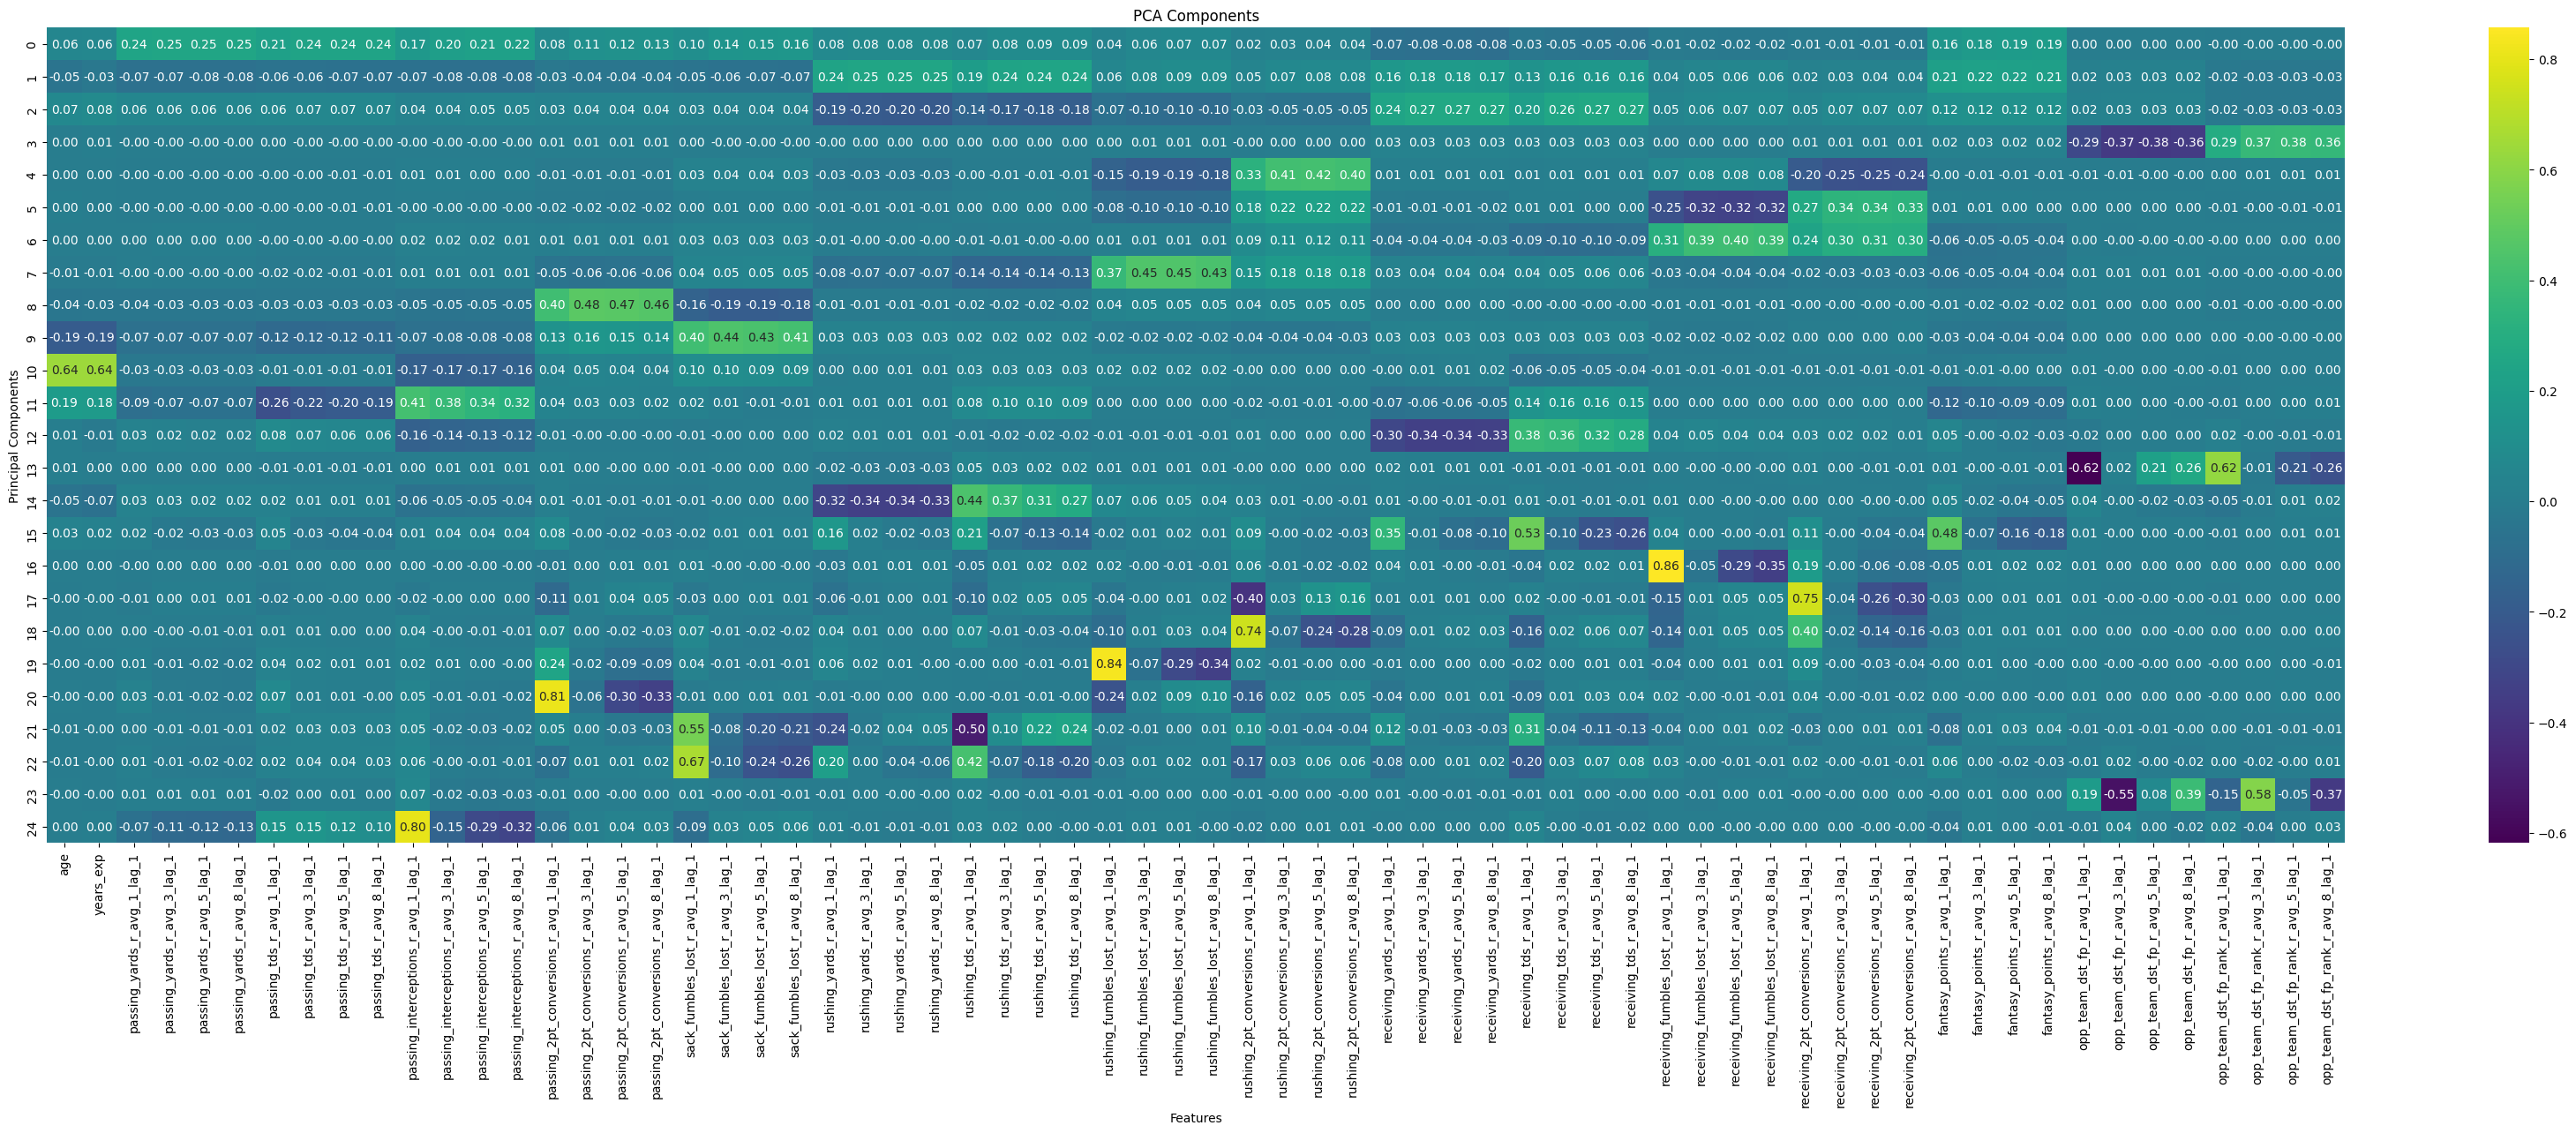

In [ ]:
# Function to plot PCA components
def plot_pca_components(pca, feature_names):
    # Create a DataFrame for the PCA components
    pca_components = pd.DataFrame(pca.components_, columns=feature_names)
    
    # Plot the PCA components
    plt.figure(figsize=(42, 12))
    sns.heatmap(pca_components, cmap='viridis', annot=True, fmt=".2f")
    plt.title("PCA Components")
    plt.xlabel("Features")
    plt.ylabel("Principal Components")
    plt.show()
    
plot_pca_components(pca, final_df_with_lags.columns[11:].drop('fantasy_points'))

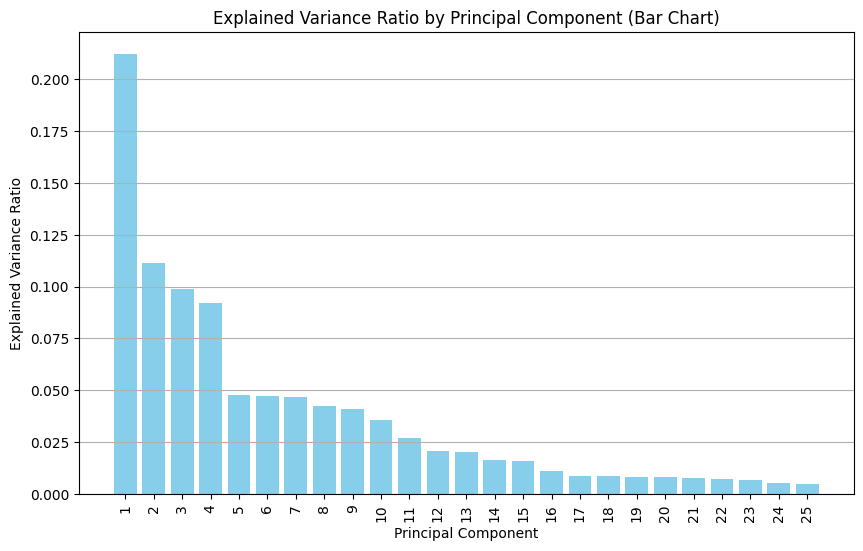

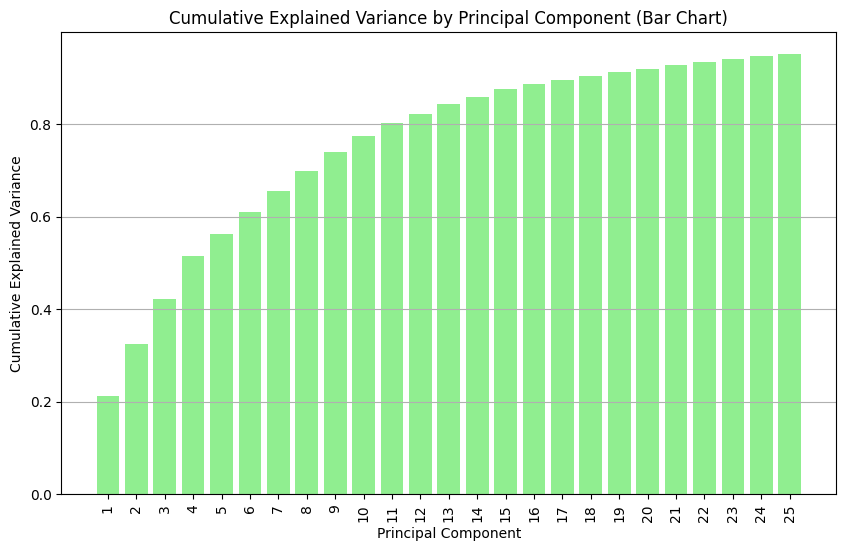

In [ ]:
# function plot PcA explained variance
def plot_explained_variance(pca):
    # Bar chart for explained variance ratio of each principal component
    plt.figure(figsize=(10,6))
    plt.bar(np.arange(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, color='skyblue')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Component (Bar Chart)')
    plt.xticks(np.arange(1, len(pca.explained_variance_ratio_)+1), rotation=90)
    plt.grid(axis='y')
    plt.show()

    # Bar chart for cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10,6))
    plt.bar(np.arange(1, len(cumulative_variance)+1), cumulative_variance, color='lightgreen')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance by Principal Component (Bar Chart)')
    plt.xticks(np.arange(1, len(cumulative_variance)+1), rotation=90)
    plt.grid(axis='y')
    plt.show()
    
plot_explained_variance(pca)

In [ ]:
# Function to extract PCA features
def extract_pca_features(pca):
    # export pca data to csv
    # pca_df = pd.DataFrame(pca.components_)
    # pca_df.to_csv('pca_components.csv', index=False)
    
    # Use the feature names from the original DataFrame columns
    feature_names = [col for col in final_df_with_lags.columns[11:] if col != 'fantasy_points']
    pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
    pca_features = pd.DataFrame(pca.components_, columns=feature_names, index=pca_columns)
    return pca_features

pca_features = extract_pca_features(pca)

In [ ]:
pca_features

,age,years_exp,passing_yards_r_avg_1_lag_1,passing_yards_r_avg_3_lag_1,passing_yards_r_avg_5_lag_1,passing_yards_r_avg_8_lag_1,passing_tds_r_avg_1_lag_1,passing_tds_r_avg_3_lag_1,passing_tds_r_avg_5_lag_1,passing_tds_r_avg_8_lag_1,...,fantasy_points_r_avg_5_lag_1,fantasy_points_r_avg_8_lag_1,opp_team_dst_fp_r_avg_1_lag_1,opp_team_dst_fp_r_avg_3_lag_1,opp_team_dst_fp_r_avg_5_lag_1,opp_team_dst_fp_r_avg_8_lag_1,opp_team_dst_fp_rank_r_avg_1_lag_1,opp_team_dst_fp_rank_r_avg_3_lag_1,opp_team_dst_fp_rank_r_avg_5_lag_1,opp_team_dst_fp_rank_r_avg_8_lag_1
PC1,0.060674,0.063471,0.244420,0.249687,0.249986,0.249702,0.212854,0.235825,0.239240,0.240169,...,0.187092,0.188714,0.001862,0.001223,0.001160,0.000977,-0.002226,-0.001654,-0.001378,-0.000987
PC2,-0.048162,-0.025597,-0.072380,-0.074753,-0.075223,-0.075435,-0.056405,-0.064824,-0.066774,-0.067809,...,0.215503,0.209220,0.018990,0.025529,0.025344,0.024885,-0.021448,-0.027406,-0.027257,-0.026494
PC3,0.072598,0.081016,0.059390,0.059782,0.059661,0.059524,0.062008,0.066162,0.066093,0.065852,...,0.122737,0.121067,0.021991,0.030652,0.031045,0.029739,-0.022295,-0.030312,-0.030531,-0.028724
PC4,0.003354,0.005425,-0.000544,-0.001108,-0.001086,-0.001225,0.001314,-0.000052,-0.000120,-0.000288,...,0.024433,0.023527,-0.290897,-0.369299,-0.375297,-0.363255,0.291250,0.369056,0.375736,0.363107
PC5,0.001056,0.002000,-0.003366,-0.002903,-0.003143,-0.003386,-0.003949,-0.004835,-0.005146,-0.005329,...,-0.005441,-0.005475,-0.005142,-0.005856,-0.004794,-0.003904,0.003512,0.007210,0.005999,0.005607
PC6,0.004495,0.003602,-0.004321,-0.004540,-0.004659,-0.004772,-0.003382,-0.004938,-0.005359,-0.005637,...,0.004198,0.001260,0.002111,0.001285,0.001604,0.001779,-0.005233,-0.004217,-0.005110,-0.005180
PC7,0.003401,0.000691,0.003751,0.004294,0.004405,0.004363,-0.004556,-0.003243,-0.002541,-0.002148,...,-0.047389,-0.042981,0.001035,-0.002781,-0.001176,-0.001743,-0.001346,0.002428,0.001310,0.002346
PC8,-0.011583,-0.013293,-0.001308,-0.002248,-0.002414,-0.002612,-0.015128,-0.015194,-0.014482,-0.013892,...,-0.043359,-0.040237,0.007024,0.006695,0.006661,0.006755,-0.004350,-0.003757,-0.003899,-0.003992
PC9,-0.037363,-0.034632,-0.036244,-0.034904,-0.034325,-0.034373,-0.025995,-0.028079,-0.027905,-0.028868,...,-0.015760,-0.016400,0.007346,0.002465,0.002675,0.002637,-0.008330,-0.004372,-0.004204,-0.004586
PC10,-0.192874,-0.194215,-0.073221,-0.073338,-0.073601,-0.073573,-0.115319,-0.117535,-0.116016,-0.112401,...,-0.042243,-0.043289,0.001300,0.002157,0.002428,0.001877,0.000213,-0.001239,-0.001497,-0.000581


In [ ]:
# Find 3 max values for each principal component and format them nicely
max_contributing_features_df = pd.DataFrame()

for pc in pca_features.index:
    # Get absolute values and find top 4 features
    top_4_features = pca_features.loc[pc].abs().nlargest(4)
    
    # Create a series with feature names and their values
    feature_series = pd.Series({
        'PC': pc,
        'Top_1': f"{top_4_features.index[0]} ({top_4_features.values[0]:.3f})",
        'Top_2': f"{top_4_features.index[1]} ({top_4_features.values[1]:.3f})",
        'Top_3': f"{top_4_features.index[2]} ({top_4_features.values[2]:.3f})",
        'Top_4': f"{top_4_features.index[3]} ({top_4_features.values[3]:.3f})",
        'Explained_Variance_Ratio': f"{pca_features.loc[pc].abs().sum():.3f}"
    })
    
    max_contributing_features_df = pd.concat([max_contributing_features_df, feature_series.to_frame().T], ignore_index=True)

max_contributing_features_df.set_index('PC', inplace=True)
max_contributing_features_df

,Top_1,Top_2,Top_3,Top_4,Explained_Variance_Ratio
PC,,,,,
PC1,passing_yards_r_avg_5_lag_1 (0.250),passing_yards_r_avg_8_lag_1 (0.250),passing_yards_r_avg_3_lag_1 (0.250),passing_yards_r_avg_1_lag_1 (0.244),6.228
PC2,rushing_yards_r_avg_5_lag_1 (0.251),rushing_yards_r_avg_3_lag_1 (0.251),rushing_yards_r_avg_8_lag_1 (0.250),rushing_tds_r_avg_5_lag_1 (0.242),6.508
PC3,receiving_yards_r_avg_5_lag_1 (0.268),receiving_yards_r_avg_3_lag_1 (0.267),receiving_tds_r_avg_8_lag_1 (0.267),receiving_tds_r_avg_5_lag_1 (0.267),6.407
PC4,opp_team_dst_fp_rank_r_avg_5_lag_1 (0.376),opp_team_dst_fp_r_avg_5_lag_1 (0.375),opp_team_dst_fp_r_avg_3_lag_1 (0.369),opp_team_dst_fp_rank_r_avg_3_lag_1 (0.369),3.308
PC5,rushing_2pt_conversions_r_avg_5_lag_1 (0.415),rushing_2pt_conversions_r_avg_3_lag_1 (0.411),rushing_2pt_conversions_r_avg_8_lag_1 (0.404),rushing_2pt_conversions_r_avg_1_lag_1 (0.325),4.070
PC6,receiving_2pt_conversions_r_avg_5_lag_1 (0.342),receiving_2pt_conversions_r_avg_3_lag_1 (0.337),receiving_2pt_conversions_r_avg_8_lag_1 (0.332),receiving_fumbles_lost_r_avg_5_lag_1 (0.325),4.042
PC7,receiving_fumbles_lost_r_avg_5_lag_1 (0.398),receiving_fumbles_lost_r_avg_3_lag_1 (0.394),receiving_fumbles_lost_r_avg_8_lag_1 (0.386),receiving_fumbles_lost_r_avg_1_lag_1 (0.311),4.165
PC8,rushing_fumbles_lost_r_avg_3_lag_1 (0.450),rushing_fumbles_lost_r_avg_5_lag_1 (0.448),rushing_fumbles_lost_r_avg_8_lag_1 (0.433),rushing_fumbles_lost_r_avg_1_lag_1 (0.371),4.606
PC9,passing_2pt_conversions_r_avg_3_lag_1 (0.480),passing_2pt_conversions_r_avg_5_lag_1 (0.475),passing_2pt_conversions_r_avg_8_lag_1 (0.460),passing_2pt_conversions_r_avg_1_lag_1 (0.403),3.742


### XGBoost Model with PCA

<Figure size 1000x800 with 0 Axes>

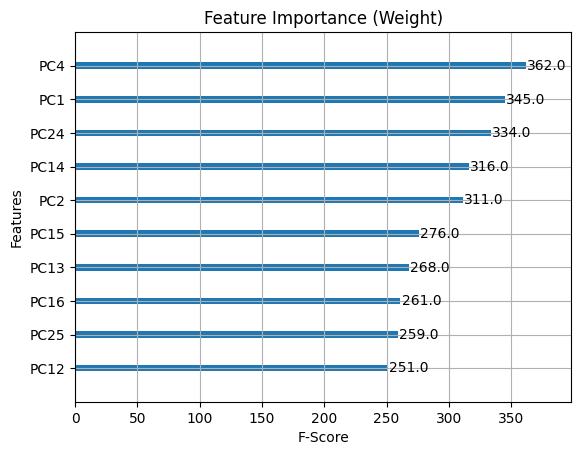

<Figure size 1000x800 with 0 Axes>

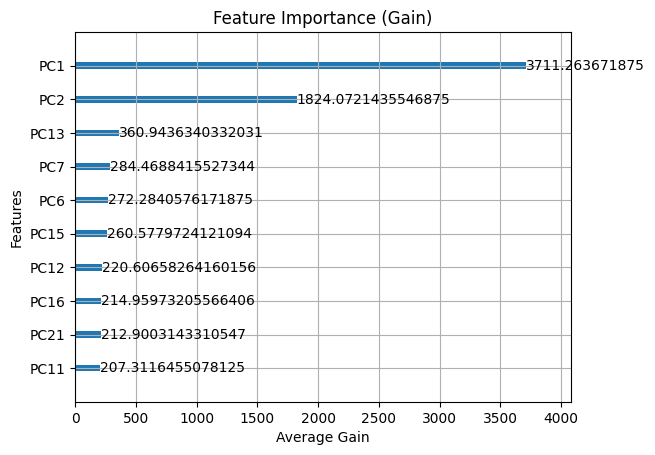

In [ ]:
# Use the trained model to plot feature importance
import matplotlib.pyplot as plt
import xgboost as xgb

def plot_feature_importance(model, feature_names):
    feature_names = feature_names.tolist() if isinstance(feature_names, pd.Index) else feature_names
    model.get_booster().feature_names = feature_names
    plt.figure(figsize=(10, 8))
    xgb.plot_importance(model, importance_type='weight', max_num_features=10, xlabel='F-Score', )
    plt.title("Feature Importance (Weight)")
    plt.show()
    plt.figure(figsize=(10, 8))
    xgb.plot_importance(model, importance_type='gain', max_num_features=10, xlabel='Average Gain')
    plt.title("Feature Importance (Gain)")
    plt.show()

feature_names = pca_features.index.tolist() if isinstance(pca_features.index, pd.Index) else pca_features.index
# Use the correct feature names for the model
plot_feature_importance(model, feature_names)

In [ ]:
# Plot Correlation Heatmap
# import seaborn as sns

# def plot_correlation_heatmap(model, feature_names):
#     feature_names = feature_names.tolist() if isinstance(feature_names, pd.Index) else feature_names
#     model.get_booster().feature_names = feature_names
#     # Create a DataFrame from the feature names
#     X = final_df_with_lags[feature_names].copy()
#     y = final_df_with_lags['fantasy_points'].copy()
    
    
#     # scaler = MinMaxScaler()
#     # X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#     plt.figure(figsize=(12, 10))
#     corr = X.corr()
#     sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
#     plt.title("Feature Correlation Heatmap")
#     plt.show()

# X = final_df_with_lags.iloc[:, 11:-1]  # Features (all columns except first 11 and last column)
# # X = X.drop(columns=['fantasy_points'])  # Drop target variable
# plot_correlation_heatmap(X)

Learning Rate: 0.01, MAE: 4.193765164020757
Learning Rate: 0.02, MAE: 3.912171667084216
Learning Rate: 0.03, MAE: 3.836404178136877
Learning Rate: 0.04, MAE: 3.8158521320610044
Learning Rate: 0.05, MAE: 3.8107583378787355
Learning Rate: 0.06, MAE: 3.8092248142576093
Learning Rate: 0.07, MAE: 3.8024167632339023
Learning Rate: 0.08, MAE: 3.804754479554409
Learning Rate: 0.09, MAE: 3.804903878505124
Learning Rate: 0.1, MAE: 3.8064899525861002


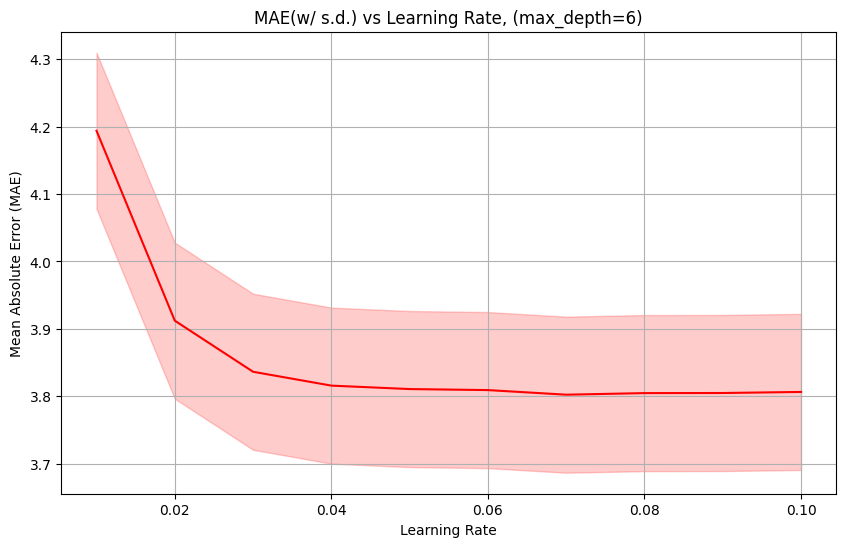

In [ ]:
# Use the trained model to plot MAE against various learning rates with area of std deviation as shaded region
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
def plot_mae_vs_learning_rate(X_train_pca, y_train, X_test_pca, y_test, learning_rates):
    mae_values = []
    for lr in learning_rates:
        model = XGBRegressor(learning_rate=lr)
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        mae = mean_absolute_error(y_test, y_pred)
        mae_values.append(mae)
        mae_values_std = np.std(mae_values)
        print(f"Learning Rate: {lr}, MAE: {mae}")

    plt.figure(figsize=(10, 6))
    plt.fill_between(learning_rates, np.array(mae_values) - mae_values_std, np.array(mae_values) + mae_values_std, alpha=0.2, color='r')
    plt.plot(learning_rates, mae_values, color='r')
    plt.xlabel('Learning Rate')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE(w/ s.d.) vs Learning Rate, (max_depth=6)')
    plt.grid(True)
    plt.show()

plot_mae_vs_learning_rate(X_train_pca, y_train, X_test_pca, y_test, learning_rates)

Max Depth: 3, MAE: 4.262522158739673
Max Depth: 4, MAE: 4.224580454832221
Max Depth: 5, MAE: 4.206303046294627
Max Depth: 6, MAE: 4.193765164020757
Max Depth: 7, MAE: 4.188733084759289
Max Depth: 8, MAE: 4.186369175841729
Max Depth: 9, MAE: 4.188852645611535
Max Depth: 10, MAE: 4.192731899235508


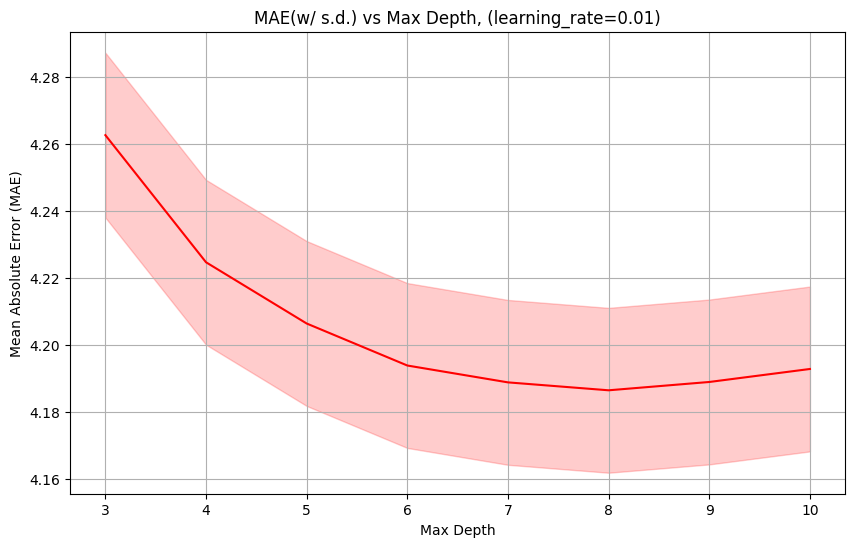

In [ ]:
# Use the trained model to plot MAE against various max_depth with area of std deviation as shaded region
max_depths = [3, 4, 5, 6, 7, 8, 9, 10]
def plot_mae_vs_max_depth(X_train_pca, y_train, X_test_pca, y_test, max_depths):
    mae_values = []
    for md in max_depths:
        model = XGBRegressor(max_depth=md, learning_rate=0.01)
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        mae = mean_absolute_error(y_test, y_pred)
        mae_values.append(mae)
        mae_values_std = np.std(mae_values)
        print(f"Max Depth: {md}, MAE: {mae}")

    plt.figure(figsize=(10, 6))
    plt.fill_between(max_depths, np.array(mae_values) - mae_values_std, np.array(mae_values) + mae_values_std, alpha=0.2, color='r')
    plt.plot(max_depths, mae_values, color='r')
    plt.xlabel('Max Depth')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE(w/ s.d.) vs Max Depth, (learning_rate=0.01)')
    plt.grid(True)
    plt.show()

plot_mae_vs_max_depth(X_train_pca, y_train, X_test_pca, y_test, max_depths)

 99%|===================| 12115/12193 [00:41<00:00]        

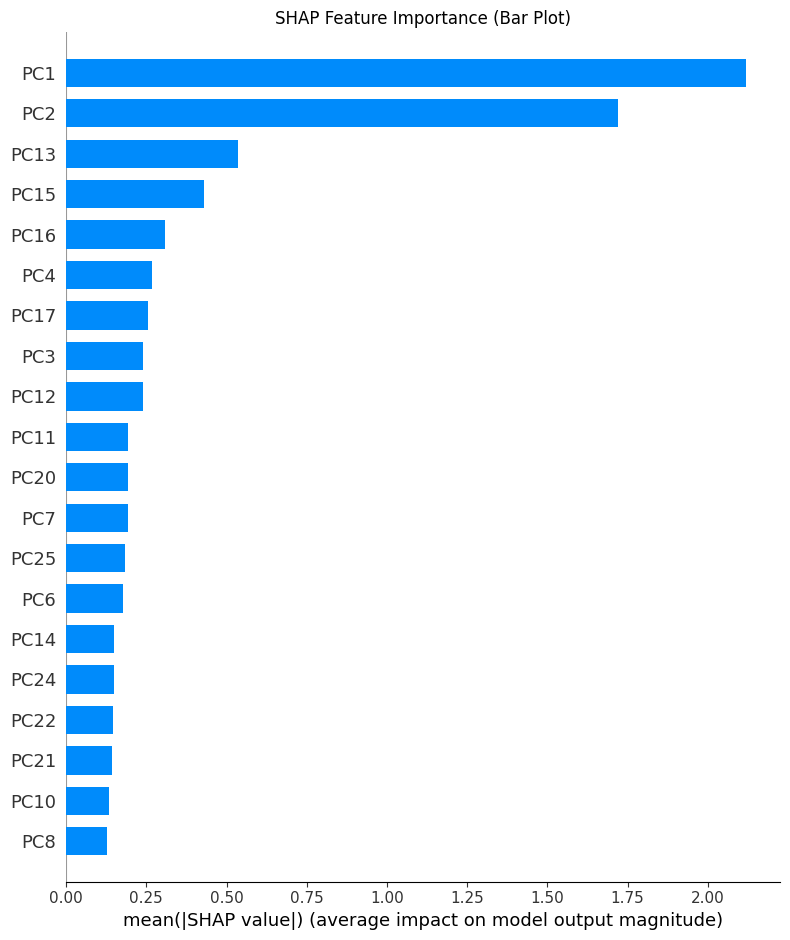

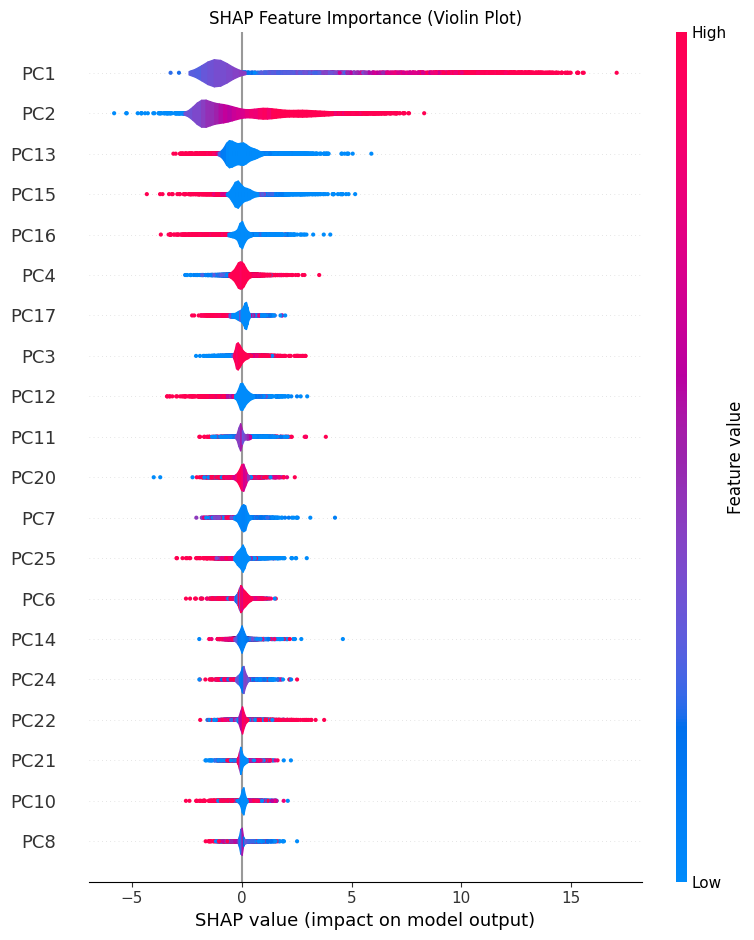

In [ ]:
# Plot feature importance using SHAP values
import shap

def plot_shap_feature_importance(model, X_test_pca):
    # Create a SHAP explainer
    explainer = shap.Explainer(model, X_test_pca)
    
    # Calculate SHAP values
    shap_values = explainer(X_test_pca)

    # Use simple PC names
    feature_names = [f"PC{i+1}" for i in range(X_test_pca.shape[1])]

    # Create figure with larger size for better readability
    plt.figure(figsize=(15, 10))
    
    # Summary plot (bar)
    shap.summary_plot(shap_values, X_test_pca, 
                     feature_names=feature_names, 
                     plot_type="bar",
                     show=False)
    plt.title("SHAP Feature Importance (Bar Plot)")
    plt.tight_layout()
    plt.show()

    # Summary plot (violin)
    plt.figure(figsize=(15, 10))
    shap.summary_plot(shap_values, X_test_pca, 
                     feature_names=feature_names, 
                     plot_type="violin",
                     show=False)
    plt.title("SHAP Feature Importance (Violin Plot)")
    plt.tight_layout()
    plt.show()
    
plot_shap_feature_importance(model, X_test_pca)

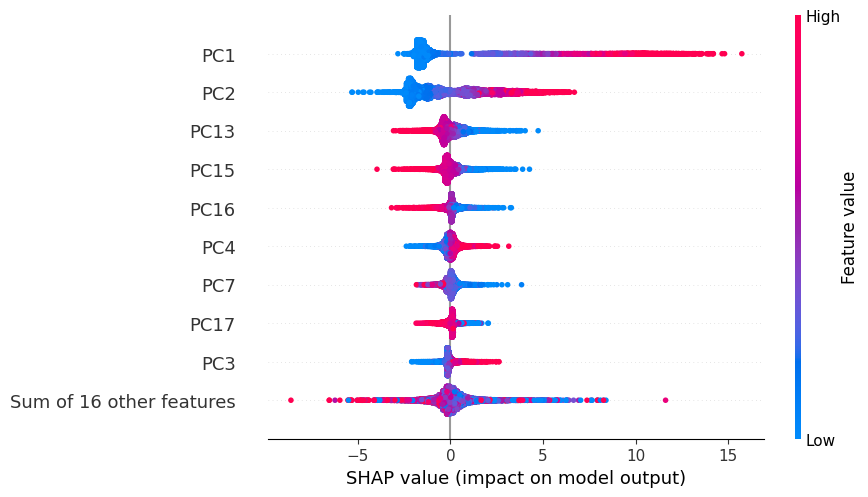

<Figure size 640x480 with 0 Axes>

In [ ]:
# Function to use SHAP to explain the machine learning model behavior with SHAP beeswarm plot
import shap

def plot_shap_beeswarm(model, X_test_pca):
    # Convert X_test_pca to DataFrame with PC names as features
    feature_names = [f"PC{i+1}" for i in range(X_test_pca.shape[1])]
    X_test_pca_df = pd.DataFrame(X_test_pca, columns=feature_names)
    
    # Create explainer and calculate SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test_pca_df)
    
    # Plot beeswarm
    plt.figure(figsize=(10, 6))
    shap.plots.beeswarm(shap_values)
    plt.tight_layout()

plot_shap_beeswarm(model, X_test_pca)

In [ ]:
# Function to use model to predict fantasy points for all weeks in final_df_with_lags, keeping 'player_id' for mapping back to player names later
def predict_fantasy_points(model, pca, final_df_with_lags):
    """
    Predict fantasy points for each player's next game using the trained model.
    
    Args:
        model: Trained XGBoost model
        pca: Trained PCA model
        final_df_with_lags: DataFrame containing player stats with lagged features
        
    Returns:
        DataFrame: Predicted fantasy points with player info
    """
    final_df_with_lags = final_df_with_lags.copy()
    
    # Get features for prediction (exclude first 11 columns and target variable)
    X_ = final_df_with_lags.iloc[:, 11:].drop(columns=['fantasy_points'])
    
    # Scale features using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_)
    
    # Apply PCA transformation
    X_pca = pca.transform(X_scaled)
    
    # Make predictions using the PCA-transformed data
    predicted_fantasy_points = model.predict(X_pca)
    
    final_df_with_lags['predicted_fantasy_points'] = predicted_fantasy_points

    return final_df_with_lags[['player_id', 'player_name', 'position_group', 'team', 'season', 'week', 'fantasy_points', 'predicted_fantasy_points']]

# Predict fantasy points using the last trained model and PCA
predicted_fantasy_points = predict_fantasy_points(model, pca, final_df_with_lags)
predicted_fantasy_points

,player_id,player_name,position_group,team,season,week,fantasy_points,predicted_fantasy_points
0,00-0007091,M.Hasselbeck,QB,IND,2014,4,-0.20,2.753691
1,00-0007091,M.Hasselbeck,QB,IND,2014,16,7.04,3.714329
2,00-0007091,M.Hasselbeck,QB,IND,2014,17,9.40,6.227607
3,00-0007091,M.Hasselbeck,QB,IND,2015,4,15.38,13.464453
4,00-0007091,M.Hasselbeck,QB,IND,2015,5,16.22,17.950560
...,...,...,...,...,...,...,...,...
60964,00-0039921,T.Benson,RB,ARI,2024,10,8.70,4.495158
60965,00-0039921,T.Benson,RB,ARI,2024,12,1.80,7.699771
60966,00-0039921,T.Benson,RB,ARI,2024,13,2.00,4.433640
60967,00-0039921,T.Benson,RB,ARI,2024,14,1.90,3.168824


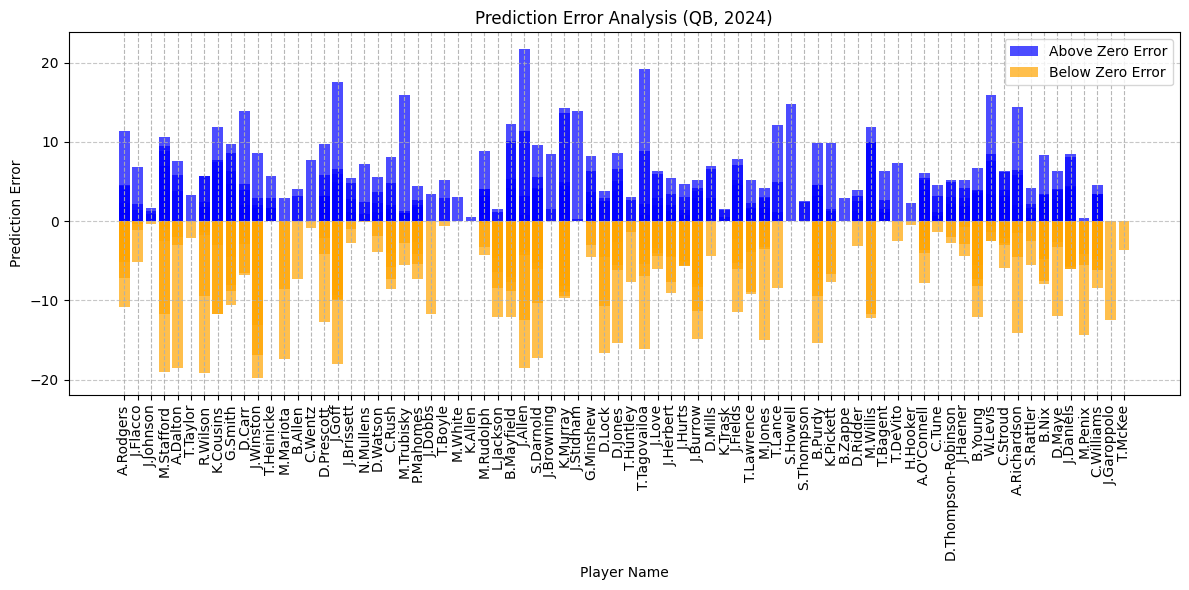

In [ ]:
# Function for Prediction error analysis
def analyze_prediction_errors(predicted_fantasy_points):
    predicted_fantasy_points = predicted_fantasy_points.copy()
    # 2024 season only
    predicted_fantasy_points = predicted_fantasy_points[predicted_fantasy_points['season'] == 2024]
    # All QB position_group only
    predicted_fantasy_points = predicted_fantasy_points[predicted_fantasy_points['position_group'] == 'QB']
    predicted_fantasy_points['prediction_error'] = predicted_fantasy_points['predicted_fantasy_points'] - predicted_fantasy_points['fantasy_points']

    # Convert prediction_error to percent_error - not absolute
    predicted_fantasy_points['percent_error'] = (predicted_fantasy_points['prediction_error'] / predicted_fantasy_points['fantasy_points'])

    # Above and below zero errors
    above_zero = predicted_fantasy_points[predicted_fantasy_points['prediction_error'] >= 0]
    below_zero = predicted_fantasy_points[predicted_fantasy_points['prediction_error'] < 0]

    plt.figure(figsize=(12, 6))

    # Plot above 0 error chart with blue color and alpha 0.7
    plt.bar(above_zero['player_name'], above_zero['prediction_error'], color='blue', alpha=0.7, label='Above Zero Error')
    # Plot below 0 error chart with orange color and alpha 0.7
    plt.bar(below_zero['player_name'], below_zero['prediction_error'], color='orange', alpha=0.7, label='Below Zero Error')
    # All vertical grid lines throughout the plot
    plt.grid(axis='x', linestyle='--', alpha=0.9)
    # All horizontal grid lines throughout the plot
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xlabel('Player Name')
    plt.ylabel('Prediction Error')
    plt.title('Prediction Error Analysis (QB, 2024)')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

analyze_prediction_errors(predicted_fantasy_points)


## 2025 Predictions

In [ ]:
# Load player game-level stats for 2025 season to identify current rosters
# player_stats_2025 = nfl.load_player_stats(2025)
# player_stats_pandas_2025 = player_stats_2025.to_pandas()
# player_stats_pandas_2025 = player_stats_pandas_2025[player_stats_pandas_2025['season_type'] != 'POST']
# player_stats_pandas_2025

In [ ]:
# Create Complete Team Defense Dataframes
# def create_team_defense_df(complete_data_df):
#     # Filter for defensive positions
#     defensive_positions = ['DL', 'LB', 'DB']
#     team_defense_df = complete_data_df[complete_data_df['pos_abb'].isin(defensive_positions)].copy()
    
#     return team_defense_df

# team_defense_df = create_team_defense_df(complete_data_df)
# team_defense_df.columns